-----------------------------------------------------------------------------------------------------------------------
# **Sistema de recomendación aplicado a productos de compras de supermercado**
-----------------------------------------------------------------------------------------------------------------------

--------------------
## **Contexto**
--------------------

En el sector minorista, especialmente en supermercados, comprender los patrones de compra de los clientes es fundamental para diseñar estrategias de ventas más efectivas. A través del análisis de cestas de mercado (market basket analysis), las empresas pueden descubrir asociaciones entre productos que los consumidores tienden a comprar juntos. Este conocimiento permite optimizar la disposición de los productos en tienda, diseñar promociones y mejorar la gestión del inventario.

-----------------------
## **Objetivo**
-----------------------

El presente informe tiene como objetivo identificar patrones de compra y relaciones entre productos dentro de un supermercado, utilizando un análisis de reglas de asociación sobre un conjunto de datos reales que contiene 38,765 transacciones de clientes durante el año 2014 y parte de 2015. Este análisis busca responder preguntas clave como:

* ¿Qué productos suelen comprarse juntos?

* ¿Qué artículos son más propensos a ser adquiridos si un cliente compra un producto específico?

* ¿Qué combinaciones pueden ser estratégicas para promociones o colocación de productos?

El método aplicado se basa en el algoritmo Apriori para la detección de conjuntos frecuentes y reglas de asociación.


------------------------------------
## **Descripción del Dataset**
------------------------------------

El dataset utilizado corresponde a un historial de transacciones de un supermercado, titulado "Groceries Dataset", el cual contiene 38,765 registros. La base de datos está estructurada en tres columnas principales:

* Member_number: Código único asignado a cada cliente (3,898 clientes únicos).

* Date: Fecha en que se realizó la transacción (728 fechas distintas, que abarcan poco más de un año).

* itemDescription: Nombre del producto adquirido (167 productos únicos en total).

Cada fila representa la compra de un producto individual por un cliente en una fecha específica, lo que permite reconstruir las cestas de compra para el análisis de asociaciones entre productos.


## **Preparación inicial y carga de datos**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("heeraldedhia/groceries-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/groceries-dataset


In [2]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

file_path =  f"{path}/Groceries_dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


Se observa que el dataset contiene información de:

- 38,765 registros correspondientes a compras individuales.
- 3 columnas principales: Member_number, Date y itemDescription.
- 3,898 clientes únicos, 728 fechas únicas y 167 productos distintos.

### **Análisis Exploratorio de los Datos (EDA)**


Distribución temporal:
Se procedió a convertir la columna de fechas al formato datetime para facilitar su manipulación. Luego, se generaron variables adicionales como:

* Semana del año (Week)

* Mes del año (Month)


In [4]:
# Tamaño promedio de las cestas de compra (productos por transacción: cliente + fecha)
basket_size = data.groupby(['Member_number', 'Date']).size()
basket_size.describe()

print("\nInformación general del dataset:")
print(data.info())

print("\nNúmero de clientes únicos:", data['Member_number'].nunique())
print("Número de fechas únicas:", data['Date'].nunique())
print("Número de productos únicos:", data['itemDescription'].nunique())




Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None

Número de clientes únicos: 3898
Número de fechas únicas: 728
Número de productos únicos: 167



Se observa que el dataset contiene información de:

- 38,765 registros correspondientes a compras individuales.
- 3 columnas principales: Member_number, Date y itemDescription.
- 3,898 clientes únicos, 728 fechas únicas y 167 productos distintos.

## **Conversión de Fechas y Limpieza Básica**

In [5]:
# Conversión de fechas y creación de variables temporales
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month

## **Patrones Iniciales Detectados**

### Productos más frecuentemente adquiridos

In [6]:
# Top 10 productos más frecuentes
top_products = data['itemDescription'].value_counts().head(10)
print("\nTop 10 productos más comprados:")
print(top_products)


Top 10 productos más comprados:
itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64


Se observa que **whole milk** y **other vegetables** son los productos más adquiridos, seguidos de panadería, bebidas y lácteos.


## **Cálculo del Tamaño de las Cestas de Compra**

In [7]:
# Agrupamos por cliente y fecha para reconstruir las cestas

basket_size = data.groupby(['Member_number', 'Date']).size()

# Estadísticas descriptivas del tamaño de las cestas
print("\nEstadísticas descriptivas del tamaño de las cestas de compra:")
print(basket_size.describe())


Estadísticas descriptivas del tamaño de las cestas de compra:
count    14963.000000
mean         2.590724
std          1.117469
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
dtype: float64


**Principales observaciones:**

- La mayoría de las cestas contienen entre **1 y 5 productos**.
- Esto sugiere que se trata principalmente de compras pequeñas, probablemente de reposición o consumo inmediato.

**Nota:** Hasta este punto hemos cargado, explorado y validado el dataset. El siguiente paso será preparar los datos para la aplicación del algoritmo Apriori, convirtiendo el dataset al formato de matriz binaria (one-hot encoding por cesta de compra).


## **Transformación de las Transacciones a Formato de Cestas.**

En esta etapa, se reorganizaron las transacciones a nivel de cliente y fecha, generando una lista de productos por cada cesta de compra. Posteriormente, se aplicó un codificador tipo **Transaction Encoder** para transformar la información en una matriz binaria, donde:

- Cada columna representa un producto.
- Cada fila representa una transacción.
- Los valores son 1 (producto presente en la cesta) o 0 (producto ausente).

El total de transacciones únicas para el análisis final fue de **14,963**, lo que representa el número de cestas de compra distintas a analizar.


In [8]:
# Agrupamos las transacciones por cliente y fecha, generando listas de productos por cesta
transactions = [x['itemDescription'].tolist() for _, x in data.groupby(['Member_number', 'Date'])]

# Aplicamos Transaction Encoder para obtener el one-hot encoding de las cestas
tencoder = TransactionEncoder()
te_array = tencoder.fit(transactions).transform(transactions)

# Generamos el dataframe codificado
basket_df = pd.DataFrame(te_array, columns=tencoder.columns_)

# Dimensión del dataframe resultante
print("\nTamaño del dataframe codificado:", basket_df.shape)


Tamaño del dataframe codificado: (14963, 167)


**Nota:** Los datos ya se encuentran en el formato adecuado para aplicar el algoritmo Apriori, que identificará los conjuntos de productos que aparecen frecuentemente de forma conjunta en las cestas de compra.

## **Generación de Reglas de Asociación**

Para este análisis se estableció un umbral mínimo de soporte de **0.1%**, lo que significa que solo se consideraron aquellos conjuntos de productos que aparecieron en al menos el 0.1% del total de transacciones analizadas.

Además del soporte, se añadieron dos columnas adicionales a los resultados:

- **Longitud del itemset:** Número de productos contenidos en cada combinación.
- **Número de ocurrencias absolutas:** Cantidad de veces que apareció cada combinación en el total de transacciones (calculado como soporte multiplicado por el número total de transacciones).

Finalmente, los itemsets se ordenaron de forma descendente según su soporte, permitiendo identificar las combinaciones más frecuentes dentro del dataset y preparar el terreno para la generación de reglas de asociación.


In [9]:
# Extracción de itemsets frecuentes
frequent_itemsets = apriori(basket_df, min_support=0.001, use_colnames=True)

# Añadimos columnas de longitud y número de ocurrencias
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets['count'] = frequent_itemsets['support'] * len(basket_df)

# Mostramos los itemsets más frecuentes
print("\nItemsets frecuentes (Top 5):")
print(frequent_itemsets.sort_values(by='support', ascending=False).head())


Itemsets frecuentes (Top 5):
      support            itemsets  length   count
146  0.157923        (whole milk)       1  2363.0
90   0.122101  (other vegetables)       1  1827.0
109  0.110005        (rolls/buns)       1  1646.0
123  0.097106              (soda)       1  1453.0
147  0.085879            (yogurt)       1  1285.0


**Nota:** A continuación se procederá a la generación de reglas de asociación a partir de estos conjuntos frecuentes para obtener patrones interpretables de comportamiento de compra.


## **Análisis de Resultados - Pares de Productos Más Frecuentes**


A continuación se analizan los pares de productos (itemsets de longitud 2) más frecuentes en las transacciones:


In [10]:
# Filtramos los itemsets de longitud 2
top_pairs = frequent_itemsets[(frequent_itemsets['length'] == 2)].sort_values(by='support', ascending=False)

# Mostramos los 5 pares más frecuentes
print("\nTop 5 de pares de productos más frecuentes:")
print(top_pairs.head())


Top 5 de pares de productos más frecuentes:
      support                        itemsets  length  count
625  0.014837  (whole milk, other vegetables)       2  222.0
677  0.013968        (rolls/buns, whole milk)       2  209.0
717  0.011629              (whole milk, soda)       2  174.0
740  0.011161            (whole milk, yogurt)       2  167.0
609  0.010559  (rolls/buns, other vegetables)       2  158.0


**Observaciones:**

- El producto **"whole milk"** está presente en 4 de los 5 pares más frecuentes.
- El par más común es **"other vegetables" y "whole milk"**, presente en aproximadamente el **1.5%** de las transacciones (222 veces).
- Otros pares destacados:
  - **"rolls/buns" con "whole milk"**
  - **"soda" con "whole milk"**
  - **"yogurt" con "whole milk"**
  - **"rolls/buns" con "other vegetables"**


Esto indica que los clientes tienden a combinar productos básicos como leche, vegetales y pan en sus compras habituales.


#### **Conjuntos de más de 2 productos**
Estas combinaciones triples no son extremadamente frecuentes (soportes bajos, menos del 0.15%), pero reflejan patrones interesantes de compra conjunta que pueden ayudar en estrategias de marketing, promociones o ubicación de productos. Por ejemplo, clientes que compran whole milk también tienden a comprar yogurt junto con sausage o rolls/buns en ciertas ocasiones. Estas asociaciones pueden usarse para sugerir promociones cruzadas o mejorar el layout en tienda para facilitar la compra conjunta.

In [11]:
top_triplets = frequent_itemsets[(frequent_itemsets['length'] > 2)].sort_values(by='support', ascending=False)
print("\nConjuntos de más de 2 productos más frecuentes:")
#print(top_triplets.head())
top_triplets.head()


Conjuntos de más de 2 productos más frecuentes:


,support,itemsets,length,count
749,0.001470,"(whole milk, sausage, yogurt)",3,22.0
747,0.001337,"(rolls/buns, whole milk, yogurt)",3,20.0
742,0.001203,"(rolls/buns, whole milk, other vegetables)",3,18.0
741,0.001136,"(rolls/buns, soda, other vegetables)",3,17.0
743,0.001136,"(other vegetables, whole milk, soda)",3,17.0



## **Análisis de Resultados - Conjuntos de Más de 2 Productos**

Se analizan ahora los conjuntos de productos que contienen más de dos artículos (tripletas y superiores):

In [12]:
# Filtramos los itemsets de longitud mayor a 2
top_triplets = frequent_itemsets[(frequent_itemsets['length'] > 2)].sort_values(by='support', ascending=False)

# Mostramos los conjuntos más frecuentes
print("\nConjuntos de más de 2 productos más frecuentes:")
print(top_triplets.head())


Conjuntos de más de 2 productos más frecuentes:
      support                                    itemsets  length  count
749  0.001470               (whole milk, sausage, yogurt)       3   22.0
747  0.001337            (rolls/buns, whole milk, yogurt)       3   20.0
742  0.001203  (rolls/buns, whole milk, other vegetables)       3   18.0
741  0.001136        (rolls/buns, soda, other vegetables)       3   17.0
743  0.001136        (other vegetables, whole milk, soda)       3   17.0


**Observaciones:**

Estas combinaciones triples no son extremadamente frecuentes (soportes bajos, menos del 0.15%), pero reflejan patrones interesantes de compra conjunta que pueden ayudar en estrategias de marketing, promociones o ubicación de productos. Por ejemplo:

- Los clientes que compran **whole milk** también tienden a comprar **yogurt** junto con **sausage** o **rolls/buns** en ciertas ocasiones.
- Estas asociaciones pueden ser utilizadas para sugerir promociones cruzadas o para mejorar la disposición de productos en tienda, facilitando la compra conjunta.


### **Aplicacion de reglas de asosicación**
Este código genera reglas de asociación a partir de conjuntos frecuentes de productos, sin filtrar por soporte mínimo, y extrae las columnas clave: productos que se compran juntos (antecedentes y consecuentes), junto con sus métricas principales (soporte, confianza y lift) para analizar la fuerza y frecuencia de esas relaciones.

In [13]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


### **Regla con Mayor Lift**

Se identificó la regla más fuerte según el criterio de **lift máximo**, la cual refleja la asociación más intensa entre los productos:


In [14]:
# 7.1. Regla con mayor lift
max_lift_rule = rules[rules['lift'] == rules['lift'].max()]
print("\nRegla con mayor lift:")
max_lift_rule


Regla con mayor lift:


,antecedents,consequents,support,confidence,lift
1233,"(whole milk, yogurt)",(sausage),0.00147,0.131737,2.182917
1236,(sausage),"(whole milk, yogurt)",0.00147,0.024363,2.182917


**Interpretación:**

- La regla con mayor lift indica que si un cliente compra **whole milk** y **yogurt**, es más de dos veces más probable que también compre **sausage** en esa misma compra.
- Esto refleja una fuerte relación entre estos productos, sugiriendo oportunidades para:
  - Diseñar promociones cruzadas.
  - Colocar estos productos en ubicaciones cercanas dentro de la tienda para fomentar la compra conjunta.


## **Filtrado Inteligente de Reglas de Asociación**

In [32]:
# Filtramos reglas con alta confianza y lift
filtered_rules = rules[(rules['confidence'] >= 0.15) & (rules['lift'] >= 1.1)]

# Ordenamos por lift descendente
filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)

print("\nTop 10 reglas filtradas por confianza >= 15% y lift >= 1.1:")
print(filtered_rules.head(10))


Top 10 reglas filtradas por confianza >= 15% y lift >= 1.1:
                antecedents   consequents   support  confidence      lift
1232  (whole milk, sausage)      (yogurt)  0.001470    0.164179  1.911760
1234      (sausage, yogurt)  (whole milk)  0.001470    0.255814  1.619866
1209  (rolls/buns, sausage)  (whole milk)  0.001136    0.212500  1.345594
1228        (sausage, soda)  (whole milk)  0.001069    0.179775  1.138374
1109  (semi-finished bread)  (whole milk)  0.001671    0.176056  1.114825


## **Visualización: Heatmap de Lift**

A continuación se genera un heatmap para visualizar las asociaciones más fuertes según el valor de lift entre pares de productos:

In [28]:
heatmap_data = filtered_rules.copy()

In [29]:
heatmap_data

,antecedents,consequents,support,confidence,lift
1232,"(whole milk, sausage)",(yogurt),0.001470,0.164179,1.911760
1234,"(sausage, yogurt)",(whole milk),0.001470,0.255814,1.619866
1209,"(rolls/buns, sausage)",(whole milk),0.001136,0.212500,1.345594
1228,"(sausage, soda)",(whole milk),0.001069,0.179775,1.138374
1109,(semi-finished bread),(whole milk),0.001671,0.176056,1.114825


**Regla 1**: Si un cliente compra Whole milk + Sausage ➔ Tiende a comprar Yogurt (Lift: 1.91)

- Esta es la asociación más fuerte encontrada.

- Prácticamente duplica la probabilidad de compra conjunta de Yogurt cuando el cliente ya ha adquirido Whole Milk y Sausage.

- Comercialmente es una gran oportunidad para cross-selling: podría ofrecerse Yogurt en promoción cuando estos otros dos productos aparecen en la compra.

**Regla 3**: Rolls/buns + Sausage ➔ Whole milk (Lift: 1.34)

- Combinación muy coherente: pan, embutidos y lácteos.

- Podría representar cestas orientadas a la preparación de comidas rápidas o bocadillos familiares.

- Oportunidad para combos en góndola.

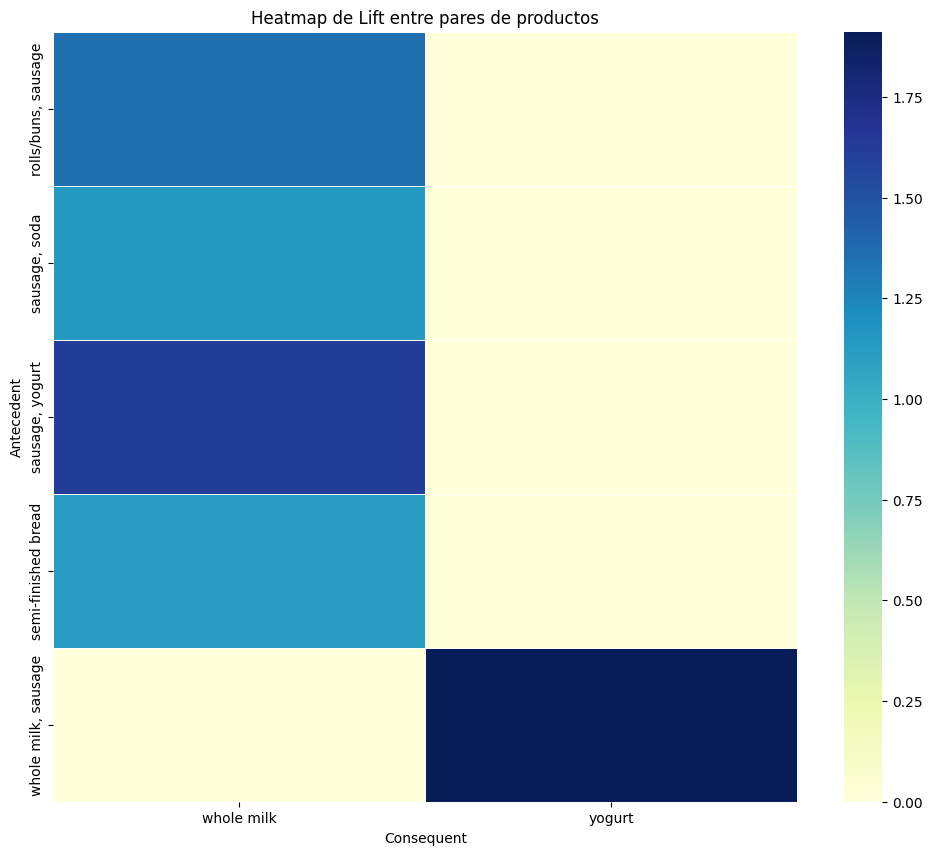

In [31]:
# Crear matriz de lift para pares de productos
heatmap_data = filtered_rules.copy()

heatmap_data['antecedent'] = heatmap_data['antecedents'].apply(lambda x: ', '.join(list(x)))
heatmap_data['consequent'] = heatmap_data['consequents'].apply(lambda x: ', '.join(list(x)))

# Aggregate duplicate entries by taking the mean of the lift values
heatmap_data = heatmap_data.groupby(['antecedent', 'consequent'])['lift'].mean().reset_index()

# Crear matriz pivote
pivot_table = heatmap_data.pivot(index='antecedent', columns='consequent', values='lift').fillna(0)

# Visualización del heatmap
plt.figure(figsize=(12,10))
sns.heatmap(pivot_table, annot=False, cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap de Lift entre pares de productos")
plt.xlabel("Consequent")
plt.ylabel("Antecedent")
plt.show()

### **Observación**

El heatmap generado permite visualizar de forma intuitiva qué pares de productos o conjuntos presentan asociaciones fuertes según la métrica de lift:

- **Alta concentración en pocas combinaciones:** Las celdas más oscuras indican asociaciones sólidas entre ciertos productos, como la relación entre "whole milk", "sausage" y "yogurt".
- **Pocas asociaciones realmente fuertes:** La mayoría de los pares presentan lift cercanos a 1 (zonas claras), reflejando independencia o asociaciones débiles.
- **Patrones comercialmente interpretables:** Los pares destacados suelen ser productos complementarios en la vida cotidiana (ej. desayuno, comidas rápidas, reposición), lo que ofrece oportunidades claras para promociones cruzadas, organización de góndolas y campañas de marketing personalizadas.

Este tipo de visualización facilita la priorización de acciones comerciales basadas en datos objetivos, permitiendo a las áreas de negocio focalizar esfuerzos donde realmente existen oportunidades de venta conjunta.


## **Análisis específico de productos relevantes**

### **Análisis Específico para "soda"**

Se realizó un análisis específico para el producto **"soda"** como antecedente en las reglas de asociación. El objetivo es explorar con qué productos suele combinarse este artículo:


In [37]:
# 7.2. Análisis específico para "soda"
product = 'soda'
soda_rules = rules[rules['antecedents'] == frozenset({product})].sort_values(by='lift', ascending=False)
print(f"\nReglas donde el antecedente es '{product}':")
#print(soda_rules.head(10))
soda_rules.head()


Reglas donde el antecedente es 'soda':


,antecedents,consequents,support,confidence,lift
889,(soda),(oil),0.001804,0.018582,1.246844
1231,(soda),"(sausage, whole milk)",0.001069,0.011012,1.229612
92,(soda),(beverages),0.001871,0.019270,1.162678
1187,(soda),"(rolls/buns, other vegetables)",0.001136,0.011700,1.108013
1097,(soda),(sausage),0.005948,0.061253,1.014975


**Observaciones:**

- Las combinaciones más relevantes para **"soda"** incluyen productos como **oil**, **whole milk + sausage**, y **beverages**.
- Sin embargo, los valores de **lift** en estas reglas son relativamente bajos (entre 1.0 y 1.25), lo que indica que las asociaciones no son tan fuertes como en el caso de otros productos analizados anteriormente.
- Esto sugiere que **soda** tiene un patrón de compra más independiente, pero aún existen oportunidades potenciales de venta cruzada, por ejemplo:
  - Ofrecer packs promocionales con **soda** y **oil**.
  - Ubicar conjuntamente **soda** con productos como **sausages** en determinadas campañas.


## **Análisis Específico para "beef"**

Se realiza ahora un análisis específico centrado en el producto **"beef"** como antecedente para evaluar sus asociaciones comerciales:


In [25]:
# 7.3. Análisis específico para "beef"
product = 'beef'
beef_rules = rules[rules['antecedents'] == frozenset({product})].sort_values(by='lift', ascending=False)
print(f"\nReglas donde el antecedente es '{product}':")
#print(beef_rules.head(10))
beef_rules.head()


Reglas donde el antecedente es 'beef':


,antecedents,consequents,support,confidence,lift
37,(beef),(frozen vegetables),0.001270,0.037402,1.335656
41,(beef),(margarine),0.001403,0.041339,1.283297
43,(beef),(newspapers),0.001671,0.049213,1.265237
23,(beef),(brown bread),0.001537,0.045276,1.203301
31,(beef),(curd),0.001270,0.037402,1.110396


**Observaciones:**

- Las reglas donde el antecedente es **beef** muestran una asociación algo más fuerte que las observadas para **soda**.
- Los productos con mayor lift asociado a **beef** son:
  - **Frozen vegetables** (lift: 1.33)
  - **Margarine** (lift: 1.28)
  - **Newspapers** (lift: 1.26)
  - **Brown bread** (lift: 1.20)
- Estos resultados sugieren que los clientes que compran carne de res tienden también a incluir acompañamientos de cocina o productos habituales de hogar.
- Desde un punto de vista comercial, puede ser útil:
  - Agrupar **beef** con vegetales congelados y productos de cocina en las góndolas.
  - Ofrecer combos promocionales para preparar comidas completas.


## **Conclusiones y Recomendaciones Comerciales**



**Conclusiones:**

- **Whole milk** y **other vegetables** actúan como productos ancla dentro de las cestas de compra, participando recurrentemente en múltiples asociaciones relevantes.
- Existen patrones sólidos de compra conjunta entre **lácteos, panadería y embutidos**, indicando hábitos de consumo orientados a la adquisición de productos complementarios para comidas cotidianas.
- **Soda** presenta asociaciones más débiles, reflejando un comportamiento de compra más independiente, aunque con oportunidades de venta cruzada puntuales.
- Las combinaciones con mayor *lift* involucran principalmente **productos frescos, lácteos y carnes frías**, sugiriendo patrones de compra para la preparación de comidas completas.
- Productos como **beef** muestran asociaciones moderadas con acompañamientos culinarios, como **frozen vegetables**, **margarine** y **brown bread**.

**Recomendaciones Comerciales:**

- **Promociones combinadas:** Diseñar paquetes promocionales que incluyan productos frecuentemente asociados como **whole milk**, **yogurt**, **other vegetables** y **sausages**.
- **Optimización del layout de tienda:** Ubicar estratégicamente productos asociados en góndolas contiguas o zonas de alto tránsito, facilitando la compra conjunta.
- **Campañas de marketing personalizadas:** Implementar acciones de *cross-selling* ofreciendo cupones de descuento para **sausages** a clientes que adquieren regularmente **yogurt** o **whole milk**.
- **Planificación de inventario inteligente:** Ajustar el aprovisionamiento de productos asociados durante períodos de mayor actividad comercial para garantizar la disponibilidad conjunta de estos artículos.
